In [7]:
from pandas_datareader import data as pdr
from datetime import date
import yfinance as yf

yf.pdr_override()
import pandas as pd

ticker_list=["AAPL", "MSFT", "AMZN", "TSLA", "GOOGL", "GOOG"]
today = date.today()
# We can get data by our choice by giving days bracket
start_date= "2020-11-30"
# end_date="2020-11-30"

files=[]
def getData(ticker):
    data = pdr.get_data_yahoo(ticker, start=start_date, end=today)
    # dataname= ticker+"_"+str(today)
    files.append((data,ticker))
    
for tik in ticker_list:
    getData(tik)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [8]:
closing_price = []
for stock_df in files:
    closing_price.append(stock_df[0].Close)

stocks = pd.concat(closing_price, axis = 1)
stocks.columns = ticker_list
stocks

,AAPL,MSFT,AMZN,TSLA,GOOGL,GOOG
Date,,,,,,
2020-11-30,119.050003,214.070007,3168.040039,567.599976,1754.400024,1760.739990
2020-12-01,122.720001,216.210007,3220.080078,584.760010,1795.359985,1798.099976
2020-12-02,123.080002,215.369995,3203.530029,568.820007,1824.969971,1827.949951
2020-12-03,122.940002,214.240005,3186.729980,593.380005,1821.839966,1826.770020
2020-12-04,122.250000,214.360001,3162.580078,599.039978,1823.760010,1827.989990
...,...,...,...,...,...,...
2022-04-04,178.440002,314.970001,3366.929932,1145.449951,2859.429932,2872.850098
2022-04-05,175.059998,310.880005,3281.100098,1091.260010,2811.820068,2821.260010
2022-04-06,171.830002,299.500000,3175.120117,1045.760010,2730.959961,2743.520020


In [9]:
stocks.pct_change(1).mean()

AAPL     0.001180
MSFT     0.001067
AMZN     0.000103
TSLA     0.002396
GOOGL    0.001361
GOOG     0.001362
dtype: float64

In [11]:
import numpy as np

log_return = np.log(stocks/stocks.shift(1))
log_return.head()

,AAPL,MSFT,AMZN,TSLA,GOOGL,GOOG
Date,,,,,,
2020-11-30,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-01,0.030362,0.009947,0.016293,0.029785,0.023079,0.020996
2020-12-02,0.002929,-0.003893,-0.005153,-0.027637,0.016358,0.016465
2020-12-03,-0.001138,-0.005261,-0.005258,0.042271,-0.001717,-0.000646
2020-12-04,-0.005628,0.000560,-0.007607,0.009493,0.001053,0.000668


In [13]:
from scipy.optimize import minimize

def get_ret_vol_sr(weights): 
    weights = np.array(weights)
    ret = np.sum(log_return.mean() * weights) * 252
    vol = np.sqrt(np.dot(weights.T,np.dot(log_return.cov()*252,weights)))
    sr = ret/vol 
    return np.array([ret,vol,sr])


# minimize negative Sharpe Ratio
def neg_sharpe(weights): 
    return get_ret_vol_sr(weights)[2] * -1

# check allocation sums to 1
def check_sum(weights): 
    return np.sum(weights) - 1

# create constraint variable
cons = ({'type':'eq','fun':check_sum})

# create weight boundaries
bounds = ((0,1),(0,1),(0,1),(0,1),(0,1), (0,1))


# initial guess
init_guess = [0.17, 0.16, 0.17, 0.16, 0.17, 0.17]

opt_results = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)

In [14]:
opt_results

     fun: -1.270530697801902
     jac: array([ 4.21121716e-04,  6.00850582e-03,  1.08210023e+00,  1.03165209e-03,
        1.13040358e-02, -2.86668539e-04])
 message: 'Optimization terminated successfully'
    nfev: 70
     nit: 10
    njev: 10
  status: 0
 success: True
       x: array([2.39052151e-01, 0.00000000e+00, 1.01481323e-15, 8.91123794e-02,
       0.00000000e+00, 6.71835469e-01])

In [15]:
opt_results.x

array([2.39052151e-01, 0.00000000e+00, 1.01481323e-15, 8.91123794e-02,
       0.00000000e+00, 6.71835469e-01])

In [32]:
ticker_list

['AAPL', 'MSFT', 'AMZN', 'TSLA', 'GOOGL', 'GOOG']

In [36]:
opt_results.x[-1]*100

67.18354693157619

In [23]:
get_ret_vol_sr(opt_results.x)

array([0.30967986, 0.24374056, 1.2705307 ])

In [27]:
ticker_list[2]

'AMZN'

In [30]:
for i in range(6):
    print(ticker_list[i], opt_results.x[i])

AAPL 0.2390521512503877
MSFT 0.0
AMZN 1.0148132334464322e-15
TSLA 0.08911237943385028
GOOGL 0.0
GOOG 0.6718354693157619


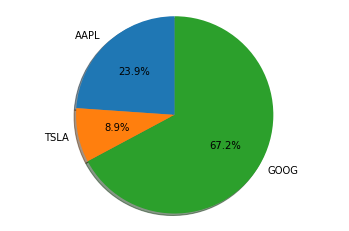

In [43]:
import matplotlib.pyplot as plt

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
updated_ticker_list = ['AAPL', 'TSLA', 'GOOG']
opt_weights = [0.2390521512503877*100,  8.911237943385029, 67.18354693157619]
explode = (0, 0, 0)  

fig1, ax1 = plt.subplots()
ax1.pie(opt_weights, explode=explode, labels=updated_ticker_list, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.savefig(r'C:\Users\saina\OneDrive - City University of Hong Kong\Desktop\cityu\Cityu Year 4\FYP\code\frontend_react\public\images\opt_portfolio.jpg')

plt.show()